## Introduction

This past summer, I worked in a molecular pathology bioinformatics team of a large hospital in New England.  During that time, I became aware of the problem of somatic variant calling.  This refers to the process molecular pathologists go through when looking at genomic data from cancer patients; specifically, it refers to deciding which mutations found in patients' cancer cell genomes should be reported to the patient's oncologist.  Variants that are reported are suspected of directly contributing to a patient's cancer and/or being clinically actionable.  

It can take a molecular pathologist 15-30 minutes or more to complete the variant calling process for a single patient; with backlogs potentially in the hundreds of cases, this is a substantial amount of time.  There are dozens of different features that a molecular pathologist must examine in the variant calling process.  The lab I worked with has amassed genomic data from several thousand cancer patients, with each patient averaging 10 mutations flagged by a bioinformatics pipeline for further review.  Each mutation in the set was deliberately reported or not reported by one or more of the reviewing pathologists; our labels are comprised of these reporting decisions.

My aim in this project is to apply machine learning to variant calling- specifically, to demonstrate the feasibility of building a binary classifier that takes in data relating to a single mutation for a single patient, and outputs a boolean value corresponding to "report" or "don't report".  If successfull, this could significantly reduce the time required for molecular pathologists to complete cases, and would in turn significantly increase the throughput of patients.

## Importing libraries

We'll begin by importing all the libraries we'll need for the project:

In [1]:
#Imports

import pandas as pd
import numpy as np

import math

import matplotlib
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

/Users/mzomnir/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Getting the Data

The data we require for this project is spread out among three different databases in the hospital.  The first is a MongoDB database that contains the core sequencing data on all the patients that have come through the lab.  The second is a Greenplum database that contains population data and various score metrics for different types of mutations.  Finally, the third system is a home-grown LIMS (laboratory information management system) database that contains the required labels, as well as data including case dates and pathologists.

My initial step was to query data from all three of these databases (via an RDP connection and SQL queries for each database), merge it into a single pandas dataframe, and perform some data cleansing.  For the purposes of this notebook, I have imported data from those databases.  Please note that the underlying data will **not** be exposed or available to readers of this notebook, beyond the charts and printouts below.

In [2]:
#Given three csv files containing data described above: merge and cleanse them, and finish with a single
#unified DataFrame:

#First, we import our three csv files as DataFrames
mongo_df = pd.read_csv('mongodb_data.csv')
greenplum_df = pd.read_csv('greenplum_data.csv')
lims_df = pd.read_csv('lims_data.csv')

#We'll create a unique key column, 'unique' in each of our datasets.  We do this by concatenating two columns,
#"variant_id" and "cid", that exist in all three datasets, and which together form a unique identifier for every
#instance in the datasets:
mongo_df['unique'] = mongo_df['variant_id'] + mongo_df['cid']
greenplum_df['unique'] = greenplum_df['variant_id'] + greenplum_df['cid']
lims_df['unique'] = lims_df['variant_id'] + lims_df['cid']

#Before we merge the dataframes, let's drop columns we won't be needing further
drop_col_list = ['cid', 'variant_id', 'approved_pathologist']
mongo_df = mongo_df.drop(drop_col_list, 1)
greenplum_df = greenplum_df.drop(drop_col_list, 1)
lims_df = lims_df.drop(drop_col_list, 1)

#Now, we'll merge our three dataframes into a single dataframe, using the 'unique' column as our key
df_full = mongo_df.merge(greenplum_df,on='unique',how='left').merge(lims_df,on='unique',how='left')

#A small subset of variants was read by multiple pathologists, and thus we have duplicate
#rows in our dataset for those variants.  In every case, the pathologists agreed on the label for that variant,
#so we can (and should) remove these duplicate rows from our dataset:
df_full = df_full.drop_duplicates(subset=['unique'])

#The three columns dealing with secondary site diagnoses are sparse (because in the majority of cases,
#there is no secondary site diagnosis, as the cancer has not metastasized).  In later research, it might be worth
#preserving this information, as metastatic status could potentially carry information on the pathogenicity of
#a particular mutation.  However, for the purposes of this project, we'll omit these columns.
secondary_site_cols = ['secondary_site', 'secondary_site_diagnosis', 'secondary_sub_site']
df_full = df_full.drop(secondary_site_cols,1)

#Lastly, we can now remove the unique identifier column before we start with our modeling
df_full = df_full.drop('unique',axis=1)

Formal feature descriptions and values for our dataset are given in the following table:

<img src="Features_table.png" style="width: 600px;"/>

After an initial review of the dataset, I decided to apply some filters to whittle down the dataset a bit further:
1. Include only point mutations; do not include indels (insertions/deletions)
2. Include only instances with variant frequency >= 0.05

The rationale for 1. is to ensure we're not comparing apples with oranges (the vast majority of the variants in our dataset are point mutations, anyhow, so we don't lose much by doing this).  The rationale for 2. is that variant frequencies under 0.05 can often be the result of noise or minor assay contamination.

In [3]:
#Filter our Data_Frame based on the above three points:

#Include only point mutations (known as snv/single nucleotide variants, or equivalently as
#snp/single nucleotide polymorphisms):
df_full = df_full[df_full['var_type'] == 'snv']

#Now that all variants are snv's we can simply remove the var_type column:
df_full= df_full.drop('var_type', 1)

#Include only instances with variant frequency >= 0.05 ('af' stands for 'allelic frequency', which is
#equivalent to variant frequency)
df_full = df_full[df_full['af'] >= 0.05]

We'll also constrict the number of labels from four down to two, in order to allow for a binary classifier.  The four pre-existing labels were {"Yes", "Checked", "Maybe", "No"}.  "Yes" means reported; "Checked" means the mutation raised some concerns but was ultimately not reported; "Maybe" means unsure, which in practice is treated as not reported; and "No" means not reported.  I lumped "Checked" and "Maybe" into "No", which reflects clinical practice:

In [4]:
#Note: 'vett' is the name of the labels column (as in, a variant has been 'vetted' by a pathologist)
#There are a few rows with bad/nonsensical labels; we'll get rid of those first
df_full = df_full[df_full['vett'].isin(['YES','CHECKED','MAYBE','NO'])]
df_full['vett'] = df_full['vett'].apply(lambda x : 'NO' if x in ['CHECKED','MAYBE','NO'] else 'YES')

Before we're satisfied with our dataset, we'd better check for missing values, as those will create problems downstream when we come to cross-validation.

In [5]:
#Check whether columns contain any NaN values (and display for all columns)
pd.set_option('display.max_rows', None)
print df_full.isnull().any()
print

#Let's also check how many rows contain NaN values (without mutating the original DataFrame):
df_full_copy = df_full.copy()
df_full_copy.dropna(inplace=True)

print "DataFrame shape BEFORE dropping rows with NaN values: " + str(df_full.shape)
print "DataFrame shape AFTER dropping rows with NaN values:" + str(df_full_copy.shape)

af                                    False
alt                                   False
chrom                                 False
n_alt+                                False
n_alt-                                False
n_ref+                                False
n_ref-                                False
pos                                   False
fisher_test_strand                    False
gene                                  False
primary_site                           True
primary_site_diagnosis                 True
primary_sub_site                       True
total_reads                           False
tumor_percentage                       True
variant_classification                False
codon_degeneracy                       True
sift_converted_rankscore               True
polyphen2_hdiv_rankscore               True
polyphen2_hvar_rankscore               True
lrt_converted_rankscore                True
mutationtaster_converted_rankscore    False
mutationassessor_rankscore      

We've uncovered a problem: nearly 15,000 or the 19,322 rows in our dataset contain missing (NaN) values.  Simply dropping all rows that contain NaNs would throw away most of our dataset. Furthermore, we see these are spread across 15 different columns (nearly half of our column space), so we cannot solve the problem by discarding a few columns.  Let's dive a little deeper and see how many NaN values exist for each of the affected columns:

In [6]:
#For each of the columns containing NaN values, check how many rows are affected

nan_cols = []
nan_count=0
for col in df_full.columns:
    nans = df_full[col].isnull().sum()
    if nans > 0:
        print col + ": " + str(df_full[col].isnull().sum())
        nan_cols.append(col)
    nan_count += df_full[col].isnull().sum()

primary_site: 51
primary_site_diagnosis: 55
primary_sub_site: 11834
tumor_percentage: 2497
codon_degeneracy: 177
sift_converted_rankscore: 695
polyphen2_hdiv_rankscore: 699
polyphen2_hvar_rankscore: 699
lrt_converted_rankscore: 538
mutationassessor_rankscore: 2614
fathmm_converted_rankscore: 691
provean_converted_rankscore: 695
vest3_rankscore: 742
metasvm_rankscore: 693
metalr_rankscore: 693


A few observations and strategies follow from the above findings:
1. primary_site and primary_site_diagnosis are critical features in clinical practice, so for any row that is missing either of those values, we'll discard it.
2. primary_sub_site is not as important in clinical practice, and since it's missing for ~12,000 rows, we'll drop this feature
3. For tumor_percentage, it's probably best to interpolate empty values with the median over the dataset. The same goes for codon_degeneracy.
4. For the rankscore features, it seems reasonalbe to interpolate missing values with the mean over the dataset, *IF* a row is missing only a minority of the scores.  Let's get a sense for a reasonable cutoff by getting the distribution of counts of missing rankscore values over the rows our dataset:

{1: 2159, 2: 60, 4: 4, 8: 2, 9: 482, 10: 211}


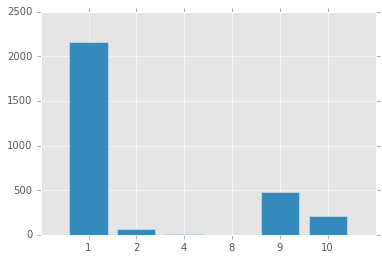

In [7]:
#We'll use matplot lib to visualize our findings
plt.style.use("ggplot")
%matplotlib inline

#Get a distribution of the counts of missing rankscore values over the dataset.
#We want to consider only the rankscore columns
nan_rankscore_cols = nan_cols[5:]
#Initialize a dict to store our distribution
nan_rankscore_counts_by_row = {}
#Populate our dict by iterating over the rows in our dataframe
for index, row in df_full.iterrows():
    rankscore_nans_in_row = 0
    for nan_rankscore_col in nan_rankscore_cols:
        if math.isnan(row[nan_rankscore_col]):
            rankscore_nans_in_row +=1
    if rankscore_nans_in_row in nan_rankscore_counts_by_row:
        nan_rankscore_counts_by_row[rankscore_nans_in_row] += 1
    else:
        #Don't include rows with no missing rankscore values in our dict,
        #since we're interested in rows with >0 missing rankscore values
        if rankscore_nans_in_row == 0:
            continue
        else:
            nan_rankscore_counts_by_row[rankscore_nans_in_row] = 1

#Print out our dict, and display the corresponding histogram
print nan_rankscore_counts_by_row

plt.bar(range(len(nan_rankscore_counts_by_row)), nan_rankscore_counts_by_row.values(), align='center')
plt.xticks(range(len(nan_rankscore_counts_by_row)), nan_rankscore_counts_by_row.keys())
plt.show()

This is encouraging: of rows that have at least one missing value for a rankscore column, the vast majority only have one such missing value.  We'll drop rows from our dataset that have four or more missing rankscore values; this will only cost us ~700 rows.

Now it's time for us to execute on our strategy for dealing with missing values in our dataset:

In [8]:
#Execute strategy for dealing with missing values in dataset

#1. primary_site and primary_site_diagnosis
df_full = df_full[df_full.primary_site_diagnosis.notnull()]
df_full = df_full[df_full.primary_site.notnull()]

#2. primary_sub_site
#for ~12,000 rows, we'll drop this feature
df_full = df_full.drop('primary_sub_site',axis=1)

#3. tumor_percentage and codon_degeneracy
tp_median = df_full['tumor_percentage'].median()
df_full['tumor_percentage'] = df_full['tumor_percentage'].apply(lambda x : tp_median if math.isnan(x) else x)

cd_median = df_full['codon_degeneracy'].median()
df_full['codon_degeneracy'] = df_full['codon_degeneracy'].apply(lambda x : cd_median if math.isnan(x) else x)

In [9]:
#4. Drop rows that are missing four or more rankscore values. For rows with 0 < missing rankscore values < 4,
#interpolate the missing rankscore values using the median of the given rankscore over the dataset.

#First, we'll get the medians for all rankscores
rankscore_medians = {}
for col in nan_rankscore_cols:
    rankscore_medians[col] = df_full[col].median()

rows_to_drop = []

#Iterate over rows. For rows with >= 4 missing rankscore values, add their indexes to the drop list.
#For rows with 1-3 missing rankscore values, interpolate these values as described above
for index, row in df_full.iterrows():
    #for the current row, keep a count of NaNs, and also a list of which rankscore columns have NaNs
    rankscore_nans_in_row = 0
    nan_cols = []
    for nan_rankscore_col in nan_rankscore_cols:
        if math.isnan(row[nan_rankscore_col]):
            rankscore_nans_in_row +=1
            nan_cols.append(nan_rankscore_col)
    #if there are four or more missing rankscore values, drop the row
    if rankscore_nans_in_row >= 4:
        rows_to_drop.append(index)
    #if there are 1-3 missing rankscore values, interpolate them
    elif rankscore_nans_in_row > 0:
        for icol in nan_cols:
            df_full.set_value(index, icol, rankscore_medians[icol])
    #otherwise, the current row has no missing values, so we move on
    else:
        continue

#Finally, we remove the flagged rows from our dataset
df_full = df_full.drop(rows_to_drop)

We've now completed our initial data extraction, aggregation, cleansing and refinement. Let's take a high-level look at it:

In [10]:
print "Shape:"
print df_full.shape
print
print "Columns and types:"
print df_full.dtypes
print
print "Head:"
print df_full.head()

Shape:
(18556, 34)

Columns and types:
af                                    float64
alt                                    object
chrom                                   int64
n_alt+                                  int64
n_alt-                                  int64
n_ref+                                  int64
n_ref-                                  int64
pos                                     int64
fisher_test_strand                    float64
gene                                   object
primary_site                           object
primary_site_diagnosis                 object
total_reads                             int64
tumor_percentage                      float64
variant_classification                 object
codon_degeneracy                      float64
sift_converted_rankscore              float64
polyphen2_hdiv_rankscore              float64
polyphen2_hvar_rankscore              float64
lrt_converted_rankscore               float64
mutationtaster_converted_rankscore    flo

## Analysing the Data (and a bit more cleansing/formatting)

Before getting to work on cross-validation, it's important to get a feel for the dataset.  The first thing we'll check is the distribution of the labels:

In [11]:
print df_full['vett'].value_counts()

NO     14505
YES     4051
Name: vett, dtype: int64


We see that our label distribution is heavily skewed towards NO (non-pathogenic).  Given this, we'll want to use stratification when we commence with cross-validation, to ensure a representative distribution of labels across folds.

Let's see how our data breaks down across genes, mutation types, and disease types:

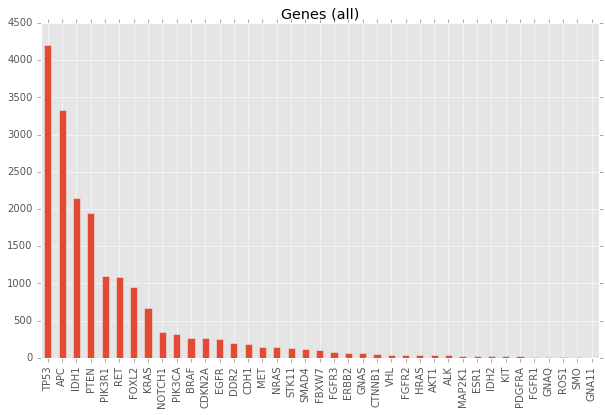

In [12]:
fig, ax = plt.subplots()
df_full['gene'].value_counts().plot(ax=ax, kind='bar', figsize=(10, 6), title="Genes (all)")
plt.show()

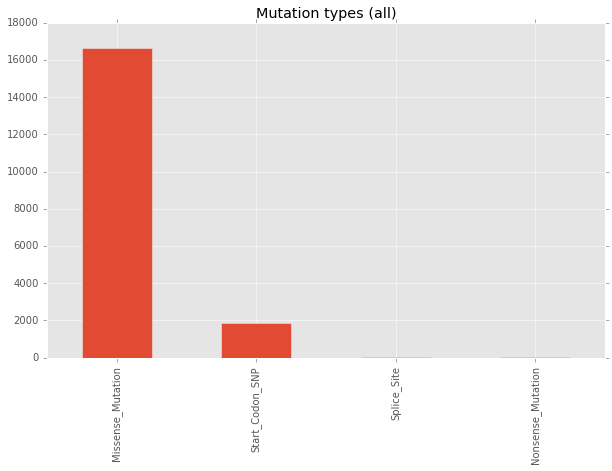

In [13]:
fig, ax = plt.subplots()
df_full['variant_classification'].value_counts().plot(ax=ax, kind='bar', figsize=(10, 6), title="Mutation types (all)")
plt.show()

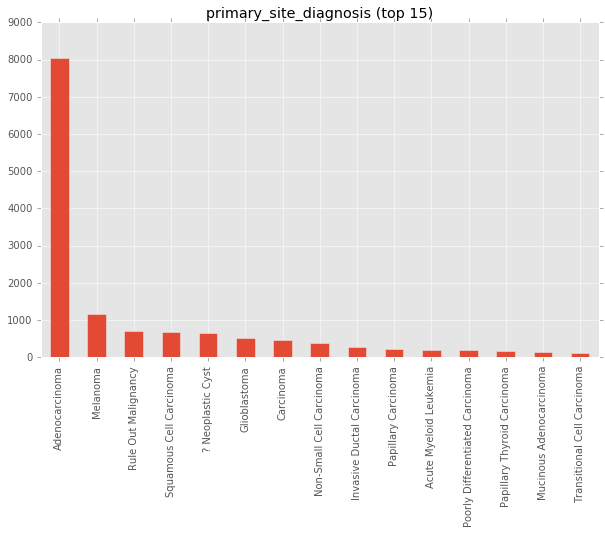

In [14]:
fig, ax = plt.subplots()
df_full['primary_site_diagnosis'].value_counts()[:15].plot(ax=ax, kind='bar', figsize=(10, 6), title="primary_site_diagnosis (top 15)")
plt.show()

We can see immediately that a few genes (TP53, ADC, IDH1, and PTEN) dominate our instance space.  This will be important to keep in mind: we might expect that our final model will perform better on mutations associated with these genes than with the other genes.  We also see that the distribution of variant classification is even more skewed, with the vast majority of our instances being missense mutations.  

Finally, we see that nearly half the instances in our dataset are Adenocarcinoma cases, though there is a long right tail.  Let's check to see just how many unique classes there are for 'primary_site' and 'primary_site_diagnosis':

In [15]:
print "primary_site class count: " + str(len(df_full['primary_site'].unique()))
print "primary_site_diagnosis class count: " + str(len(df_full['primary_site_diagnosis'].unique()))

primary_site class count: 31
primary_site_diagnosis class count: 411


The primary_site class count is reasonably low.  However, the class count for primary_site_diagnosis is quite high.  For primary_site_diagnosis, we'll convert it into a binary variable that encodes whether the class is Adenocarcinoma or not (since Adenocarcinoma accounts for nearly half the instances in our dataset).

In [16]:
df_full['primary_site_diagnosis'] = df_full['primary_site_diagnosis'].apply(lambda x : 1 if x == "Adenocarcinoma" else 0)

## One-hot encoding and label encoding

Speaking of encoding, there are two last steps we'll need to take before getting onto cross-validation: converting our labels to {0,1}, and performing one-hot encoding for our remaining categorical features ('alt', 'gene', 'primary_site', 'variant_classification', and 'chrom'):

In [17]:
#Encode label values as {YES:1, NO:0}

df_full['vett'] = df_full['vett'].apply(lambda x : 0 if x == "NO" else 1)
print df_full['vett'].value_counts()

0    14505
1     4051
Name: vett, dtype: int64


In [18]:
#CITATION: THANK YOU TO GITHUB USER "ramhiser" FOR HIS IMPLEMENTATION OF A ONE-HOT ENCODING FUNCTION,
#WHICH I HAVE DIRECTLY TAKEN AND USED.  PLEASE SEE https://gist.github.com/ramhiser/982ce339d5f8c9a769a0
 
def encode_onehot(df, cols):
    """One-hot encoding is applied to columns specified in a pandas DataFrame.
    Args:
        df (pandas DataFrame) : DataFrame of entire dataset
        cols (list) : a list of columns to encode
    
    Returns:
        df (pandas DataFrame) : the input DataFrame, now with categorical features one-hot encoded
    """
    vec = DictVectorizer()
    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df

#Before one-hot encoding our dataset, we'll formally split it into features and labels.
#We'll create a labels Series..
y = df_full['vett'].copy()
#..and a DataFrame with only our features
X = df_full.copy().drop('vett',1)

#We'll need to generate the list of categorical feature indices from X
cat_feats = ['alt', 'gene', 'primary_site', 'variant_classification', 'chrom']
cat_indices = []
for feat in cat_feats:
    cat_indices.append(X.columns.get_loc(feat))

#Finally, let's create our one-hot encoded version of our feature dataset:  
X_one_hot = encode_onehot(X, cat_feats)
#Let's display our one-hot encoded dataframe, to check that it's as expected
pd.set_option('display.max_columns', None)
print X_one_hot.shape
X_one_hot.head()


/Users/mzomnir/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: the 'outtype' keyword is deprecated, use 'orient' instead


(18556, 107)


,af,n_alt+,n_alt-,n_ref+,n_ref-,pos,fisher_test_strand,primary_site_diagnosis,total_reads,tumor_percentage,codon_degeneracy,sift_converted_rankscore,polyphen2_hdiv_rankscore,polyphen2_hvar_rankscore,lrt_converted_rankscore,mutationtaster_converted_rankscore,mutationassessor_rankscore,fathmm_converted_rankscore,provean_converted_rankscore,vest3_rankscore,cadd_raw_rankscore,cadd_phred,metasvm_rankscore,metalr_rankscore,gerp_pp_rs_rankscore,phylop7way_vertebrate_rankscore,phastcons7way_vertebrate_rankscore,siphy_29way_logodds_rankscore,alt=A,alt=C,alt=G,alt=T,chrom,gene=AKT1,gene=ALK,gene=APC,gene=BRAF,gene=CDH1,gene=CDKN2A,gene=CTNNB1,gene=DDR2,gene=EGFR,gene=ERBB2,gene=ESR1,gene=FBXW7,gene=FGFR1,gene=FGFR2,gene=FGFR3,gene=FOXL2,gene=GNA11,gene=GNAQ,gene=GNAS,gene=HRAS,gene=IDH1,gene=IDH2,gene=KIT,gene=KRAS,gene=MAP2K1,gene=MET,gene=NOTCH1,gene=NRAS,gene=PDGFRA,gene=PIK3CA,gene=PIK3R1,gene=PTEN,gene=RET,gene=ROS1,gene=SMAD4,gene=SMO,gene=STK11,gene=TP53,gene=VHL,primary_site=Abdomen,primary_site=Adrenal Gland,primary_site=Appendix,primary_site=Biliary Brush,primary_site=Bladder,primary_site=Bone,primary_site=Brain/Central Nervous System,primary_site=Breast,primary_site=Cervix,primary_site=Endometrium/Uterus,primary_site=Esophagus,primary_site=Eye,primary_site=Gastrointestinal Tract,primary_site=Head and Neck,primary_site=Hematopoietic and Lymphoid Tissue,primary_site=Kidney/Renal,primary_site=Lung,primary_site=Meninges,primary_site=Ovary,primary_site=Peritoneum,primary_site=Prostate,primary_site=Salivary Gland,primary_site=Skin,primary_site=Small Intestine,primary_site=Soft Tissue,primary_site=Thymus,primary_site=Thyroid,primary_site=Unknown,primary_site=Urinary Tract,primary_site=Vagina,primary_site=Vulva,variant_classification=Missense_Mutation,variant_classification=Nonsense_Mutation,variant_classification=Splice_Site,variant_classification=Start_Codon_SNP
24,0.55,32,21,22,22,115256529,0.411769,0,112,80.0,0.0,0.72092,0.55645,0.61374,0.5373,0.81033,0.9672,0.83827,0.90833,0.87213,0.65125,22.5,0.9423,0.91837,0.68184,0.76621,0.90892,0.71042,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25,0.48,35,29,49,21,115256529,0.075969,0,159,70.0,0.0,0.72092,0.55645,0.61374,0.5373,0.81033,0.9672,0.83827,0.90833,0.87213,0.65125,22.5,0.9423,0.91837,0.68184,0.76621,0.90892,0.71042,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
26,0.40,10,18,18,24,115256529,0.623284,0,79,60.0,0.0,0.72092,0.55645,0.61374,0.5373,0.81033,0.9672,0.83827,0.90833,0.87213,0.65125,22.5,0.9423,0.91837,0.68184,0.76621,0.90892,0.71042,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
35,0.51,32,42,36,35,115256529,0.407645,1,172,70.0,0.0,0.72092,0.55645,0.61374,0.5373,0.81033,0.9672,0.83827,0.90833,0.87213,0.65125,22.5,0.9423,0.91837,0.68184,0.76621,0.90892,0.71042,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
36,0.44,8,17,9,23,115256529,0.777932,0,73,80.0,0.0,0.72092,0.55645,0.61374,0.5373,0.81033,0.9672,0.83827,0.9083

Our one-hot encoded DataFrame looks good.  A quick visual inspection confirms that our categorical features were properly encoded and our other features were left intact.  It's time for cross-validation! 

## Cross-validation

We'll now take our fully-formed dataset and run some stratified, k-fold cross-validation experiments.  For streamlined experimentation, we'll construct a pipeline with three steps: scaling, dimensionality reduction or feature selection, and classification.  We'll generate three distinct outputs for evaluating the results of cross-validation: a simple accuracy score (i.e. percent correct), a confusion matrix, and a tuple containing precision, recall, and F1 score.  For comparison among different cross-validation runs, we'll use the F1 score (the harmonic mean of precision and recall).

In [19]:
#We'll write a function to perform cross validation, which will make it easy for us to test various combinations
#of scaling, dimensionality reduction or feature selection, and models (and their hyperparameters)

def run_cv(scaling, dim_reduct_or_feat_select, classifier, num_folds, X, y):
    """ Performs k-fold cross validation, using the specified inputs 
        Args: 
            scaling: sklearn scaling instance, e.g. StandardScaler
            dim_reduct_or_feat_select : sklearn dimensionality reduction instance, e.g. PCA,
                                        or feature selection instance, e.g. SelectKBest
            classifier : sklearn classifier, e.g. SVC
            num_folds (int) : number of folds of cross validation to perform
            X (pandas DataFrame) : dataset (without labels)
            y (pandas Series) : labels
            
        Returns: 
            result_accuracy (float) : the performance of the classifier, averaged over the k iterations
            aggregate_confusion_matrix (numpy array) : the aggregate confusion matrix (over all folds)
            result_prf1 (numpy array): precision, recall, f1 score, averaged over all folds)
    """
    
    #create list to hold results from each fold of cross validation; these will be averaged at the end
    results = np.ones(num_folds)
    cv_round = 0
    #Initialize our (empty) confusion matrix
    aggregate_confusion_matrix = np.zeros((2,2))
    #Initialize our (empty) array to hold precision, recall, and F1 score
    aggregate_prf1 = np.zeros(3)
    
    skf = StratifiedKFold(n_splits=num_folds)
    
    #Cross validation loop
    for train_index, test_index in skf.split(X, y):
        
        #First: we generate the train/test split for this round of cross validation
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #Next, we create our pipeline. We'll have three steps: scaling, dimmensionality reduction or
        #feature selection, and classification
        pipeline_clf = Pipeline(steps=[('scaling', scaling), ('dim_reduct_or_feat_select', dim_reduct_or_feat_select),
                                       ('classifier', classifier)])
        
        #Finally, we fit and test a classifier as defined by our current pipeline:
        pipeline_clf.fit(X_train, y_train)
        performance = pipeline_clf.score(X_test, y_test)
        results[cv_round] = performance
        #update our confusion matrix with this fold's results
        X_test_predictions = pipeline_clf.predict(X_test)
        fold_confusion_matrix = confusion_matrix(y_test, X_test_predictions)
        aggregate_confusion_matrix = np.add(aggregate_confusion_matrix, fold_confusion_matrix)
        #generate precision, recall, f1 score, (and exclude support), for the current round
        #Note: we use 'weighted' for the average parameter, to take label imbalance into account
        fold_prf1= precision_recall_fscore_support(y_test, X_test_predictions, average='weighted')[:3]
        aggregate_prf1 = np.add(aggregate_prf1, fold_prf1)
        cv_round += 1
     
    
    result_accuracy = np.mean(results)
    result_prf1 = aggregate_prf1/float(num_folds)
    
    return (result_accuracy, aggregate_confusion_matrix, result_prf1)

### Before we start, let's recall our purpose...

Now is a good time to revisit the purpose of the project- "to **demonstrate the feasibility** of building a binary classifier that takes in data relating to a single mutation for a single patient, and outputs a boolean value corresponding to 'pathogenic' or 'non-pathogenic'."  But what do we mean by 'feasibility'?

Consider the area in which we're working- cancer.  Specifically, we're trying to identify which mutations in cancer cell genomes are actually fueling the cancer, so that an oncologist can craft a treatment plan accordingly. If we build a model that generates too many false positives (Type I error, i.e. false alarms for specific point mutations), oncologists may not know which results to believe.  Conversely, if we build a model that generates too many false negatives (Type II error, i.e. misses real pathogenic mutations), oncologists will lose information that could be vital to treating their patients.  This is what we're capturing with the confusion matrix.

With precision, we answer the question, "what portion of truly pathogenic mutations are we catching?"  With recall, we ask, "Of all the mutations we identify as pathogenic, what portion of them are truly pathogenic?"  We want to maximize precision, so that we miss as few real mutations as possible, but we also want to maximize recall, so that we 'cry wolf' as infrequently as possible.  To strike a balance between these two objectives, we evaluate our cross-validation results on the basis of an F1-score: the harmonic mean of precision and recall.

The physicians I worked with agreed that in clinical practice, a model that achieves an F1 score above 0.90 could be useful for 'decision support'- that is to say, pathologists would use the model to assist (but not replace) their variant calling practices.  To take over variant calling entirely from humans, the model would have to achieve an F1-score greater than 0.99 (this might seem unreasonably high, but again, consider the gravity of the context).

With this in mind, let's run some cross-validation experiments with various pipelines and see how they perform.  We'll consider scaling, dimensionality reduction, feature selection, and several classifiers (with various settings for their respective hyperparameters).  We'll execute this experimentation process by implementing our own highly limited and simplistic version of a grid search.  To start, we construct our grid below:

In [20]:
#We define our own restriced and simplistic grid search, with different inputs for each pipeline stage:

scaling_choices = [None, StandardScaler()]
dim_reduct_and_kbest_choices = [None, SelectKBest(5), SelectKBest(10), SelectKBest(20),
                                PCA(n_components = 5), PCA(n_components = 10), PCA(n_components = 20)]
clf_choices = [GaussianNB(), LogisticRegression(), RandomForestClassifier(),
               RandomForestClassifier(max_depth = 10), RandomForestClassifier(max_depth = 10, n_estimators=100),
              SVC(kernel='linear'), SVC(kernel='rbf'), SVC(kernel='poly',degree=2), SVC(kernel='poly',degree=3)]

On average, a single 10-fold cross-cross validation experiment takes ~20 seconds to complete.  Let's estimate how long we expect our simple grid search to take:

In [21]:
print "Estimated Grid Search time = " + str((20.0 * len(scaling_choices)*len(dim_reduct_and_kbest_choices) * 
                                                  len(clf_choices)) / 60.0) + " minutes"

Estimated Grid Search time = 42.0 minutes


In its current form our grid search would take ~47 minutes.  That's not a terribly long time to wait around for an experiment to finish, but for our purposes we'll pare down our grid:

In [22]:
#Paring down our grid search space:

#feature scaling almost always helps, and rarely hurts
scaling_choices = [StandardScaler()]

#Limit k and n_components to {5, 10}
dim_reduct_and_kbest_choices = [None, SelectKBest(k=5), SelectKBest(k=10), PCA(n_components = 5), PCA(n_components = 10)]

#Pare down our classifier space (and test fewer hyperparameters)
clf_choices = [GaussianNB(), LogisticRegression(), RandomForestClassifier(), 
               RandomForestClassifier(max_depth = 10, n_estimators=100), 
               SVC(kernel='rbf'), SVC(kernel='poly',degree=2), SVC(kernel='poly',degree=3)]

print "New estimated Grid Search time = " + str((20.0 * len(scaling_choices)*len(dim_reduct_and_kbest_choices) * 
                                                  len(clf_choices)) / 60.0) + " minutes"

New estimated Grid Search time = 11.6666666667 minutes


Now we'll only need to wait ~12 minutes for the results of our mini grid search.  We'll write a function to carry out the grid search for us, below:

In [23]:
def grid_search_cv(scaling_list, dim_reduct_or_feat_select_list, classifier_list, num_folds, X, y):
    """ Performs a grid search, using the specified inputs 
        Args: 
            scaling_list (list) : list of scaler instances
            dim_reduct_or_feat_select (list) : list of dimensionality reduction or feature selection instances
            classifier_list (list) : list of classifier instances
            num_folds (int) : number of folds of cross-validation to perform (for each iteration of cross-validation)
            X (pandas DataFrame) : dataset (without labels)
            y (pandas Series) : labels
            
        Returns: 
            results (3-tuple) : best pipeline found; confusion matrix for best pipeline; 
            and tuple of precision, recall and F1 score for best pipeline
    """    
    num_iterations = len(scaling_list) * len(dim_reduct_or_feat_select_list) * len(classifier_list)
    
    best_f1 = 0.0
    best_pipeline = None
    best_pipeline_accuracy = 0.0
    best_pipeline_conf_mat = None
    best_pipeline_prf1 = None
    i = 0
    
    #Carry out grid search:
    #Across classifiers,..
    for clf in classifier_list:
        #Across dimensionality reducers and feature selectors,...
        for dr_fs in dim_reduct_or_feat_select_list:
            #And across scalers:
            for scaler in scaling_list:
                i += 1
                print "Currently on iteration " + str(i) + " of " + str(num_iterations)
                print
                accuracy, conf_mat, prf1 = run_cv(scaler, dr_fs, clf, num_folds, X, y)
                precion, recall, f1 = prf1
                #Each time we find new best pipeline, we print its credentials
                if f1 > best_f1:
                    best_f1 = f1
                    best_pipeline = [scaler, dr_fs, clf]
                    best_pipeline_accuracy = accuracy
                    best_pipeline_conf_mat = conf_mat
                    best_pipeline_prf1 = prf1
                    print "Found new best, F1 score = " +  str(best_f1)
                    print "scaler = " + str(scaler)
                    print "dr_fs = " + str(dr_fs)
                    print "clf = " + str(clf)
                    print
        
    results = (best_pipeline, best_pipeline_conf_mat, best_pipeline_prf1)
    return results


Now, let's run our grid search function using the scaling, dimensionality reduction, feature selection, and classifier sets we defined above:

In [ ]:
#Run grid search and print results for the best pipeline we find

gs_pipeline, gs_conf_mat, gs_prf1 = grid_search_cv(scaling_choices, dim_reduct_and_kbest_choices, clf_choices,
                                                   10, X_one_hot.values, y.values)

print "Best pipeline:"
print "Scaling = " + str(gs_pipeline[0])
print "Dim. Reduct or KBest = " + str(gs_pipeline[1])
print "Classifier = " + str(gs_pipeline[2])
print
print "Confusion Matrix:"
print gs_conf_mat
print
print "Precision = " + str(gs_prf1[0])
print "Recall = " + str(gs_prf1[1])
print "F1 Score = " + str(gs_prf1[2])


Currently on iteration 1 of 35

Found new best, F1 score = 0.90215741309
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
dr_fs = None
clf = GaussianNB(priors=None)

Currently on iteration 2 of 35



/Users/mzomnir/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [49] are constant.
  UserWarning)


Currently on iteration 3 of 35

Currently on iteration 4 of 35

Found new best, F1 score = 0.911954490336
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
dr_fs = PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
clf = GaussianNB(priors=None)

Currently on iteration 5 of 35

Currently on iteration 6 of 35

Found new best, F1 score = 0.922430989509
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
dr_fs = None
clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Currently on iteration 7 of 35

Currently on iteration 8 of 35

Currently on iteration 9 of 35

Currently on iteration 10 of 35

Currently on iteration 11 of 35

Currently on iteration 12 of 35

Currently on iterati

## Results

We see that our most promising pipeline employed a StandardScaler, PCA with 5 components, and an SVC with the (default) radial basis function as the kernel.  In ten-fold cross validation, it attained precision of 0.95, recall of 0.93, and an F1 score of 0.94.  This is above our F1 score threshold of 0.90 for a clinical utility as a decision support tool.  

From the confusion matrix, we note a bias in error toward false positives (772) over false negatives (436).  Whether this bias is preferable in clinical practice is debatable: we may intuit that it is better to raise a false alarm than to miss a truly pathogenic mutation.  But, if the false alarm is not recognized as such by the oncologist, it may give rise to a treatment regimen that is ineffective or even unnecessarily harmful (for example, if radiation is prescribed).

Speaking of clinical practice, there's another factor we should consider: model interpretability.  In practice, few physicians (or patients) would be willing to trust a 'black box' model, i.e. a model whose 'reasoning' cannot be easily understood by a human with domain expertise.  In our case, it is difficult to interpret the weights of an SVC with a non-linear kernel function.  Consider now that a random forest with only 10 trees obtained nearly as good of an F1 score at 0.93; it is highly unlikely that these two scores are in fact significantly different.  But, a physician maybe able to examine 10 decision trees in a random forest and gain some degree of comfort with the model's 'logic', and this represents a major practical advantage over an SVC.  In fact, looking at the output from our grid search function, we see that all four types of classifiers we tried achieved F1 scores above 0.90 in cross-validation.

We have now shown through cross-validation and our grid search that, with a dataset of under 19,000 mutation instances, it is indeed feasible to construct a variant calling model (for the assay from which our data was generated) that performs with precision, recall, and F1 scores above 0.90.

## Future work

The next logical step from this project would be to actually train a variant calling model, selected based on our cross-validation and grid search results, and test it in practice.  Prior to doing so, however, it would be wise to conduct a thorough error analysis over the top-performing classification pipelines we've found.  We'd want to ask questions like:
- Do different models tend towards similar or different types of error?
- Can we describe certain subsets of mutation instances that models tend to perform poorly on?  For instance, does performance tend to be poorer on mutations associated with genes rarely seen in our dataset?
- How do models generated from our dataset perform on mutation data from other assays (which have substantial feature space overlap with this project's assay).

We must also reiterate the importance of model interpretability in clinical practice.  Given the choice between two similarly performing models, a physician will nearly always choose the one whose 'logic' he or she can best interpret.  In further work, substantial thought should be given on how to make models' logic as interpretable as possible (e.g. through visualization for trees, for explanation of log-odds ratios for regression, etc.).

One thing is certain- machine learning is transforming the way clinical pathology is practiced.  For a thorough introduction, see this [JAMA article](http://jamanetwork.com/journals/jama/fullarticle/2588764?utm_source=FBPAGE&utm_medium=social_jn&utm_term=688797423&utm_content=content_engagement%7Carticle_engagement&utm_campaign=article_alert&linkId=31723767).